# Taller de Deep Learning con Pytorch
## Entrenando una CNN como clasificador

__Creado por:__ Angel Ayala ([Github](https://github.com/angel-ayala))

__Revisado:__ Francisco Cruz ([Sitio Web](http://www.franciscocruz.cl))

---

__Completado por:__ _indique su nombre aqui_

__Actualizado__: Martes 10 de Mayo, 2022

__Fecha de Entrega__: Viernes 20 de Mayo, 2022

---

# Actividad
En el siguiente tutorial veremos la aplicación de una red neuronal convolucional (CNN, del inglés _Convolutional Neural Network_) para un problema de clasificación de imágenes. Para este propósito, utilizaremos la librería PyTorch en gran parte del proceso, facilitando la carga y preprocesamiento del conjunto de datos, así como también crear, entrenar y validar nuestro modelo de la misma forma que en el taller anterior. En este taller además abordaremos el uso de _transfer learning_ y de _fine-tuning_ para acelerar el proceso de entrenamiento.

En este taller implementaremos las misma base para la creación de un modelo que corresponde a:
- Obtención del conjunto de datos.
- Análisis del conjunto de datos.
- Preprocesamiento de los datos.
- Definición del modelo.
- Entrenamiento y validación del modelo.
- Pruebas de generalización.

## Objetivos
Como objetivo de este taller se encuentra que sean capaces de crear una arquitectura de red neuronal convolucional usando las herramientas actuales para la implementación de deep learning. Para esto se espera que consigan:
- Aprender a utilizar la librería de PyTorch para ejecutar un experimento de deep learning.
- Desarrollar una CNN a partir del contenido visto en clases.
- Identificar las diferencias entre un modelo perceptrón multicapa y un modelo convolucional.
- Implementar el uso de _transfer learning_/_fine-tuning_ con arquitecturas clásicas de deep learning.
- Usar métricas de evaluación para un modelo de clasificación


# Desarrollo

Para el desarrollo de esta actividad, debemos recordar que usaremos el lenguaje de programación de Python y sus librerías asociadas para el tratamiento de variables. Dentro del notebook se encuentra todo lo necesario para realizar un experimento de clasificación de imágenes con PyTorch, a medida se avanza en el notebook se encontrarán con celdas de código completos que explican el uso o implementación de ciertas librerías que serán de utilidad para una experiencia futura, otras celdas con código parciales para ustedes complementar con la lógica faltante, y otras celdas que deberán programar por completo. Para finalizar, al final del notebook se encuentran unos enunciados de análisis de la experiencia desarrollada en este notebook.

In [ ]:
#@title Cargar Librerías
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision import datasets, transforms

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

import numpy as np
import matplotlib.pyplot as plt

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [ ]:
#@title Métodos útiles
# Definir forma de entrenamiento
def entrenar(dataloader, model, loss_fn, optimizer, quiet=True):
    model.train()  # cambia el estado para entrenamiento
    # iterar sobre el conjunto de lotes
    size = len(dataloader.dataset)
    error = []
    for batch, (X, y) in enumerate(dataloader):
        # pasa los tensores a GPU o CPU
        X, y = X.to(device), y.to(device)
        
        # Feed-forward y cálculo del error
        pred = model(X)
        loss = loss_fn(pred, y)
        error.append(loss.item())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Imprimir estado de entrenamiento
        if batch % 100 == 99 and quiet is False:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Definir forma de evaluación
def evaluar(dataloader, model):
    model.eval()  # Cambia el estado para evaluación
    test_loss, correct = 0, 0
    size = len(dataloader.dataset)
    predictions = []
    # Evita el calculo de gradientes
    with torch.no_grad():
    # Iterar sobre el conjunto de lotes
        for X, y in dataloader:
            # Pasa los tensores a GPU o CPU
            X, y = X.to(device), y.to(device)
            # Feed-forward y cálculo del error
            pred = model(X)
            # Almacena métricas
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # Almacena predicciones
            predictions.extend(pred.tolist())

    test_loss /= size
    correct /= size
    # Imprimir métricas
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return predictions

# Visualizar muestras
def show_samples(data, labels, names, size=(5, 2), unormalize=None):
    figure = plt.figure(figsize=size)
    cols, rows = size

    for i in range(1, cols * rows + 1):
        img, label = data[i], labels[i]

        if unormalize:
            img = unormalize(img)        

        figure.add_subplot(rows, cols, i)
        plt.title(names[label])
        plt.axis("off")
        plt.imshow(img)

    plt.show()

## Primera experiencia: MLP a CNN

Para esta primera experiencia usaremos el conjunto de datos de [MNIST](https://deepai.org/dataset/mnist) que contiene 70.000 imágenes en blanco y negro de 28x28 pixeles en blanco y negro que representan los dígitos del cero al nueve. Los datos se dividen en dos subconjuntos, con 60.000 imágenes pertenecientes al conjunto de entrenamiento y 10.000 imágenes pertenecientes al conjunto de prueba. La separación de las imágenes garantiza que, dado lo que un modelo adecuadamente entrenado ha aprendido previamente, pueda clasificar con precisión imágenes relevantes no examinadas previamente.

### Cargar conjunto de datos

In [ ]:
# Preprocesamiento
preprocess = transforms.Compose(
    [transforms.ToTensor(),                                 
     transforms.Normalize(mean=(0.5), std=(0.5))])

batch_size = 32

# Descargar datos de entrenamiento.
training_data = datasets.MNIST(root="./data", train=True,
                               download=True, transform=preprocess)

# Descargar datos de prueba.
test_data = datasets.MNIST(root="./data", train=False,
                           download=True, transform=preprocess)

# Separar conjunto en lotes
mnist_loader = dict()
mnist_loader['train'] = DataLoader(training_data, batch_size=batch_size,
                                   shuffle=True, num_workers=2)
mnist_loader['test'] = DataLoader(test_data, batch_size=batch_size,
                                  shuffle=False, num_workers=2)

classes = list(f"Num{dig}" for dig in range(10)) # números del 0 al 9

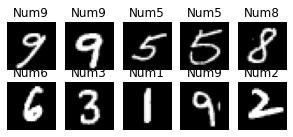

In [ ]:
#@title Visualizar muestras
# desnormalizar
def unormalize(img):
    inp = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# obtener un lote
muestras, labels = next(iter(mnist_loader['train']))
show_samples(muestras, labels, classes, unormalize=unormalize)

### Clasificación con un modelo totalmente contectado
En este caso se desarrollará una arquitectura similar al perceptrón multicapa con en donde cada pixel de la imagen corresponde a una unidad, con una capa intermedia de 500 unidades y una salida con 10 unidades, obteniendo una arquitectura de (28*28)x500x10

In [ ]:
# Definir modelo MLP
class MnistMlp(nn.Module):
    def __init__(self, n_intermedia=512, output=10):
        super(MnistMlp, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, n_intermedia),
            nn.ReLU(),
            nn.Linear(n_intermedia, n_intermedia),
            nn.ReLU(),
            nn.Linear(n_intermedia, output),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
#@title Instanciar y evaluar el modelo
epochs = 5
alfa = 1e-3

mlp = MnistMlp().to(device)
mlp_savename = "model_mlp.pth"
print(mlp)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=alfa)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    entrenar(mnist_loader['train'], mlp, loss_fn, optimizer,
             quiet=True)
    evaluar(mnist_loader['test'], mlp)

# Salvar los pesos modelo
torch.save(mlp.state_dict(), mlp_savename)
print(f"Done!, Saved PyTorch Model State to {mlp_savename}")

In [ ]:
#@title Evaluar modelo
# Instanciar modelo y cargar pesos
mlp_eval = MnistMlp()
mlp_eval.load_state_dict(torch.load(mlp_savename))
mlp_eval.to(device)

y_true = []

for i, (x_input, y_label) in enumerate(mnist_loader['test']):
    y_true.extend(y_label.tolist())

y_pred = evaluar(mnist_loader['test'], mlp_eval)
# softmax probabilities
y_pred = F.softmax(torch.tensor(y_pred), dim=1).numpy()
y_true = np.array(y_true)

print(classification_report(y_true, y_pred.argmax(axis=1),
                            target_names=classes))

In [ ]:
#@title ROC curve
# roc
idx_label = 9
roc_y_true = np.array(y_true == idx_label, dtype=float)
roc_y_pred = y_pred[:, idx_label]

# Compute ROC curve and ROC area:
fpr, tpr, _ = roc_curve(roc_y_true, roc_y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.007])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic {classes[idx_label]}')
plt.legend(loc="lower right")
plt.show()

### Definir el modelo CNN
Crear una arquitectura de CNN en PyTorch es bastante simple, sigue la misma lógica que la creación de un MLP con la única diferencia que en vez de utilizar capas lineales o totalmente conectadas, se utilizan capas convolucionales, por ejemplo:
- [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
- [nn.MaxPool](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- [nn.AvgPool](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#torch.nn.AvgPool2d)
- [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)

Otra capa que será útil para la comunicación entre capas convolucionales y totalmente conectadas es [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten)

In [ ]:
# Define model
class MnistCNN(nn.Module):
    def __init__(self, input_channels=1, out_units=10, input_size=(28, 28)):
        super(MnistCNN, self).__init__()
        raise NotImplementedError('La función aún no se ha definido.')
        # aqui se debe definir la arquitectura del modelo y sus respectivas
        # capas

    def forward(self, x):
        raise NotImplementedError('La función aún no se ha definido.')
        # aqui se debe definir como fluye la información desde la entrada
        # a la salida
        pass

In [ ]:
#@title Instanciar y evaluar el modelo
epochs = 5
alfa = 1e-3

cnn = MnistCNN().to(device)
cnn_savename = "model_cnn.pth"
print(cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=alfa)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    entrenar(mnist_loader['train'], cnn, loss_fn, optimizer,
             quiet=True)
    evaluar(mnist_loader['test'], cnn)

# Salvar los pesos modelo
torch.save(cnn.state_dict(), cnn_savename)
print(f"Done!, Saved PyTorch Model State to {cnn_savename}")

In [ ]:
#@title Evaluar modelo
# Instanciar modelo y cargar pesos
cnn_eval = MnistCNN()
cnn_eval.load_state_dict(torch.load(cnn_savename))
cnn_eval.to(device)

y_true = []

for i, (x_input, y_label) in enumerate(mnist_loader['test']):
    y_true.extend(y_label.tolist())

y_pred = evaluar(mnist_loader['test'], cnn_eval)
# softmax probabilities
y_pred = F.softmax(torch.tensor(y_pred), dim=1).numpy()
y_true = np.array(y_true)

print(classification_report(y_true, y_pred.argmax(axis=1),
                            target_names=classes))

In [ ]:
#@title ROC curve
# roc
idx_label = 9
roc_y_true = np.array(y_true == idx_label, dtype=float)
roc_y_pred = y_pred[:, idx_label]

# Compute ROC curve and ROC area:
fpr, tpr, _ = roc_curve(roc_y_true, roc_y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.007])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic {classes[idx_label]}')
plt.legend(loc="lower right")
plt.show()

## Segunda experiencia: Usando modelos pre entrenados
Los problemas de clasificación de imágenes ya han sido ampliamente abordados y hoy en día existen varios modelos con diferentes arquitecturas que han sido capaces de superar el ojo humano. Estos modelos han sido evaluados en el dataset de [ImageNet](https://image-net.org) que presenta más de 1.3 millones de imágenes entre 1000 clases diferentes de objetos.

Para esta experiencia, usaremos el modelo propuesto por [Karen Simonyan llamado VGG16](https://arxiv.org/abs/1409.1556) que presenta la siguiente arquitectura:

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fneurohive.io%2Fwp-content%2Fuploads%2F2018%2F11%2Fvgg16-1-e1542731207177.png&f=1&nofb=1" width="600"/>

Comúnmente para utilizar _transfer learning_ desde modelos pre entrenados, se reemplaza la etapa de clasificación o de capas totalmente conectadas por una a elección, y sólo son actualizados esos parámetros de la red.

Si las carácterísticas obtenidas por el modelo pre entrenado no  son suficientes, los parámetros de las capas convolucionales pueden ser actualizados pero usualmente su tasa de aprendizaje es mucho menor que el utilizado para las capas reemplazadas anteriormente, a esto se le conoce como _fine-tuning_

In [ ]:
import torchvision.models as pretained_models

### Cargar conjunto de datos
Para esta experiencia utilizaremos un conjunto más amplio en cantidad de clases a clasificar, demostrando la complejidad que puede existir en una tarea de clasificación.

Para esta parte utilizaremos el conjunto CIFAR100 que consiste de 60.000 imágenes de 32x32 imágenes a color con 100 clases agrupadas en 20 superclases.

In [ ]:
# Preprocesamiento
preprocess = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

batch_size = 32

# Descargar datos de entrenamiento.
cifar_training = datasets.CIFAR100(root="./data", train=True,
                                   download=True, transform=preprocess)

# Descargar datos de prueba.
cifar_test = datasets.CIFAR100(root="./data", train=False,
                               download=True, transform=preprocess)

# Separar conjunto en lotes
cifar_loader = dict()
cifar_loader['train'] = DataLoader(cifar_training, batch_size=batch_size,
                                   shuffle=True, num_workers=2)
cifar_loader['test'] = DataLoader(cifar_test, batch_size=batch_size,
                                  shuffle=False, num_workers=2)

In [ ]:
#@title leer etiquetas
import pickle
with open('/content/data/cifar-100-python/meta', 'rb') as fo:
    cifar_meta = pickle.load(fo)

In [ ]:
#@title Visualizar muestras
# desnormalizar
def unormalize(img):
    inp = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# obtener un lote
cifar_smpl, cifar_lbl = next(iter(cifar_loader['train']))
show_samples(cifar_smpl, cifar_lbl, cifar_meta['fine_label_names'], unormalize=unormalize)

### Comparación con CNN simple

In [ ]:
#@title Instanciar y evaluar el modelo
epochs = 5

cnn_cifar = MnistCNN(input_channels=3,
                 out_units=100,
                 input_size=(224, 224)).to(device)
cnn_cifar_savename = "model_cnn_cifar.pth"
print(cnn_cifar)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_cifar.parameters(), lr=1e-3)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    entrenar(cifar_loader['train'], cnn_cifar, loss_fn, optimizer,
             quiet=False)
    evaluar(cifar_loader['test'], cnn_cifar)

# Salvar los pesos modelo
torch.save(cnn_cifar.state_dict(), cnn_cifar_savename)
print(f"Done!, Saved PyTorch Model State to {cnn_savename}")

### Definición del modelo

In [ ]:
def VggBasedModel(n_outputs=10, fixed=True):
    # extractor de características
    # para mas información del modelo visite
    # https://pytorch.org/vision/stable/_modules/torchvision/models/vgg.html
    base_model = pretained_models.vgg16(pretrained=True)

    if fixed:  # congelar los pesos del modelo
        for param in base_model.parameters():
            param.requires_grad = False

    # agregar capa totalmente conectada
    num_ftrs = base_model.classifier[0].in_features  # número de características
    base_model.classifier = nn.Linear(num_ftrs, n_outputs)

    return base_model

In [ ]:
#@title Instanciar y entrenar el modelo
epochs = 5

vgg_based = VggBasedModel(n_outputs=100).to(device)
vgg_based_savename = "model_vgg_based.pth"
print(vgg_based)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg_based.parameters(), lr=1e-3)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    entrenar(cifar_loader['train'], vgg_based, loss_fn, optimizer,
             quiet=False)
    evaluar(cifar_loader['test'], vgg_based)

# Salvar los pesos modelo
torch.save(vgg_based.state_dict(), vgg_based_savename)
print(f"Done!, Saved PyTorch Model State to {vgg_based_savename}")

# Responda

## Para la primera experiencia:

(a) Defina una arquitectura propia de CNN e fundamente la selección de capas, conexiones y estructura definida.

(b) Usando métricas compare su modelo de CNN con MLP. Comente las diferencias encontradas y el motivo de estas.


(c) Haga un análisis respecto al nivel de complejidad para los modelos (MLP y CNN) en reconocer o clasificar entre un número u otro.

## Para la segunda experiencia:


(e) Entrene y evalúe el mismo modelo utilizado con MNIST, ahora con CIFAR100 y comente, sin aplicar ningún cambio ni ejecutar ningún código, quéé aspectos deben considerarse en la arquitectura o entrenamiento para mejorar el resultado obtenido.

(d) Para el modelo basado en VGG6, modifique la etapa de clasificación del moodelo para obtener un mejor resultado de evaluación, en caso exista, y explique por qué con las capas definidas se obtiene un resultado u otro.

(f) Si le fuera solicitado desarrollar un modelo para clasificar imágenes de productos que son embalados en una planta de alimentos.
Indique los pasos que debe llevar a cabo para obtener dicho modelo.

__Nota__: Piense en un proceso desde cero, defina las condiciones que deben cumplirse y la forma en que abordaría el problema.

### Evaluación:
- Para evaluar el trabajo se debe crear un documento pdf dónde se indique:
  - La respuesta para cada experiencia y comentarios sobre cada prueba realizada.
  - Una sección final de conclusión donde comenten sobre retropropagación y sus comentarios finales respecto a los resultados obtenidos.
- El documento debe ser nombrado como "Taller IA02 - Deep Learning - _nombreAlumno_.pdf"
  - Ejemplo "Taller IA03 - Deep Learning - Alan Turing.pdf"
- Se debe compartir el notebook y el pdf creado con <aaam@ecomp.poli.br> con copia a <francisco.cruz@ucentral.cl>, <martin.saavedra@alumnos.ucentral.cl>
y <ines.apablaza@alumnos.ucentral.cl>

### Observaciones:
- Debes crear una copia del notebook y guardarlo en Google Drive para no perder los cambios realizados.
- Recuerda agregar todo el material auxiliar necesario para fundamentar tus respuestas, referencias a artículos o trabajos relacionados, gráficos, formulas entre otros.